In [1]:
import json

with open("prompt1.json", "r") as file:
    openai_resp = json.load(file)

In [133]:
import pandas as pd

openai_resp = pd.DataFrame(openai_resp)

In [134]:
openai_resp["label"].value_counts()

label
false                             377
partly true/misleading            249
true                              205
mostly true                        71
mostly false                       51
complicated/hard to categorise     24
other                              14
Name: count, dtype: int64

In [135]:
openai_resp

,openai_resp,index,label,language
0,50,0,false,tr
1,50,1,partly true/misleading,ka
2,50,2,partly true/misleading,pt
3,50,3,true,ka
4,50,4,false,id
...,...,...,...,...
995,85,995,partly true/misleading,ar
996,0,996,partly true/misleading,ta
997,50,997,false,pt
998,100,998,complicated/hard to categorise,pt


#Simplify labels
(partly true is assumed true)

In [136]:
# remove other and complicated labels
openai_resp = openai_resp[
    ~openai_resp["label"].isin(["complicated/hard to categorise", "other"])
]

In [137]:
# simplify the truth-value to binary, so we can approximate some accuracy by delineating false as anything below 50
def simplify_truth(row):
    if row["label"] in ["false", "mostly false"]:
        return 0
    else:
        return 1


openai_resp["simple_truth"] = openai_resp.apply(simplify_truth, axis=1)

openai_resp["simple_truth"].value_counts()

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_23288/289968943.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openai_resp['simple_truth'] = openai_resp.apply(simplify_truth, axis=1)


simple_truth
1    534
0    428
Name: count, dtype: int64

#Convert the prompt 1 scores to binary

In [139]:
# Remove responses which couldn't evaluate to a score
anomalies = []


def catch_anomalies(row):
    if len(row["openai_resp"]) > 4:
        anomalies.append(row)

    else:
        return row  # Returning the row unchanged


openai_resp = openai_resp.apply(catch_anomalies, axis=1).dropna()


# Convert the score to binary hard classification >=50 implies true
def convert_Score(row):
    if int(row["openai_resp"]) >= 50:
        return 1
    else:
        return 0


openai_resp["simple_score"] = openai_resp.apply(convert_Score, axis=1)

In [140]:
print(anomalies)

[openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         1
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         1
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         1
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleading
language                            it
simple_truth                         1
Name: 999, dtype: object, openai_resp                         50
index                              999
label           partly true/misleadin

In [141]:
len(anomalies)

10

Hence there are 10 entries where ChatGpt couldn't evaluate a score

In [73]:
openai_resp

,openai_resp,index,label,language,simple_truth,simple_score
0,50,0.0,false,tr,0,1
1,50,1.0,partly true/misleading,ka,1,1
2,50,2.0,partly true/misleading,pt,1,1
3,50,3.0,true,ka,1,1
4,50,4.0,false,id,0,1
...,...,...,...,...,...,...
994,50,994.0,true,ro,1,1
995,85,995.0,partly true/misleading,ar,1,1
996,0,996.0,partly true/misleading,ta,1,0
997,50,997.0,false,pt,0,1


#Overall data accuracy score

In [74]:
from sklearn.metrics import accuracy_score

accuracy_score(openai_resp["simple_truth"], openai_resp["simple_score"], normalize=True)

0.5832449628844114

#Overall data micro f1 score

In [75]:
from sklearn.metrics import f1_score

f1_score(openai_resp["simple_truth"], openai_resp["simple_score"], average="micro")

0.5832449628844114

In [76]:
openai_resp_grouped = pd.DataFrame(openai_resp).groupby("language")

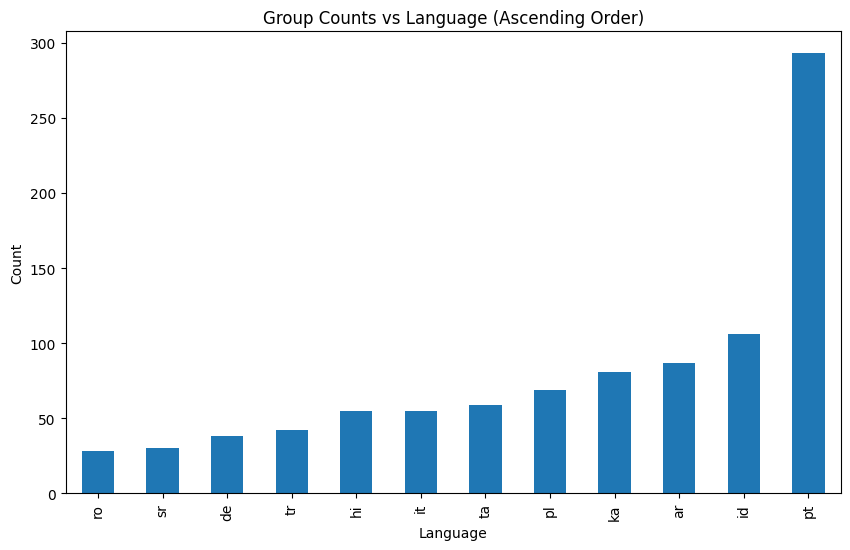

In [130]:
import matplotlib.pyplot as plt

group_counts = openai_resp_grouped.size()

# Sort the groups based on the counts in ascending order
sorted_group_counts = group_counts.sort_values()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sorted_group_counts.plot(kind="bar")
plt.xlabel("Language")
plt.ylabel("Count")
plt.title("Group Counts vs Language (Ascending Order)")
plt.show()

In [142]:
def calculate_metrics(group):
    accuracy = accuracy_score(
        group["simple_truth"], group["simple_score"], normalize=True
    )
    f1 = f1_score(group["simple_truth"], group["simple_score"], average="micro")
    count = len(group)
    return pd.Series({"accuracy": accuracy, "f1": f1, "count": count})


# Apply the custom function to each group and construct a new DataFrame
metrics_df = openai_resp_grouped.apply(calculate_metrics).reset_index()

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_23288/3303902291.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = openai_resp_grouped.apply(calculate_metrics).reset_index()


In [143]:
print(metrics_df)

   language  accuracy        f1  count
0        ar  0.643678  0.643678   87.0
1        de  0.605263  0.605263   38.0
2        hi  0.345455  0.345455   55.0
3        id  0.415094  0.415094  106.0
4        it  0.800000  0.800000   55.0
5        ka  0.728395  0.728395   81.0
6        pl  0.739130  0.739130   69.0
7        pt  0.573379  0.573379  293.0
8        ro  0.678571  0.678571   28.0
9        sr  0.233333  0.233333   30.0
10       ta  0.610169  0.610169   59.0
11       tr  0.571429  0.571429   42.0


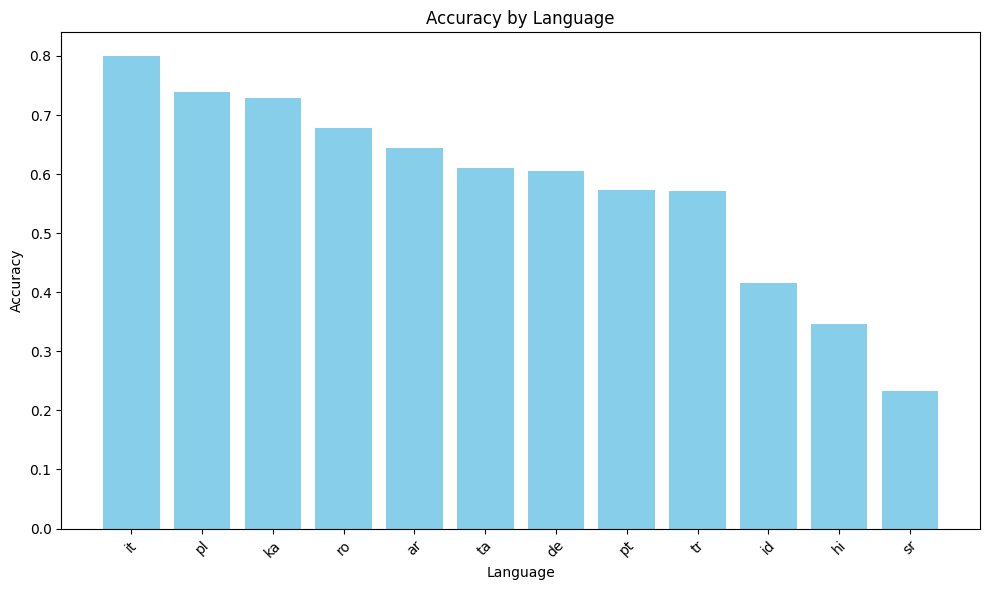

In [110]:
import matplotlib.pyplot as plt


# Sort the data by accuracy in descending order for better visualization
data_sorted = metrics_df.sort_values(by="accuracy", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(data_sorted["language"], data_sorted["accuracy"], color="skyblue")
plt.xlabel("Language")
plt.ylabel("Accuracy")
plt.title("Accuracy by Language")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

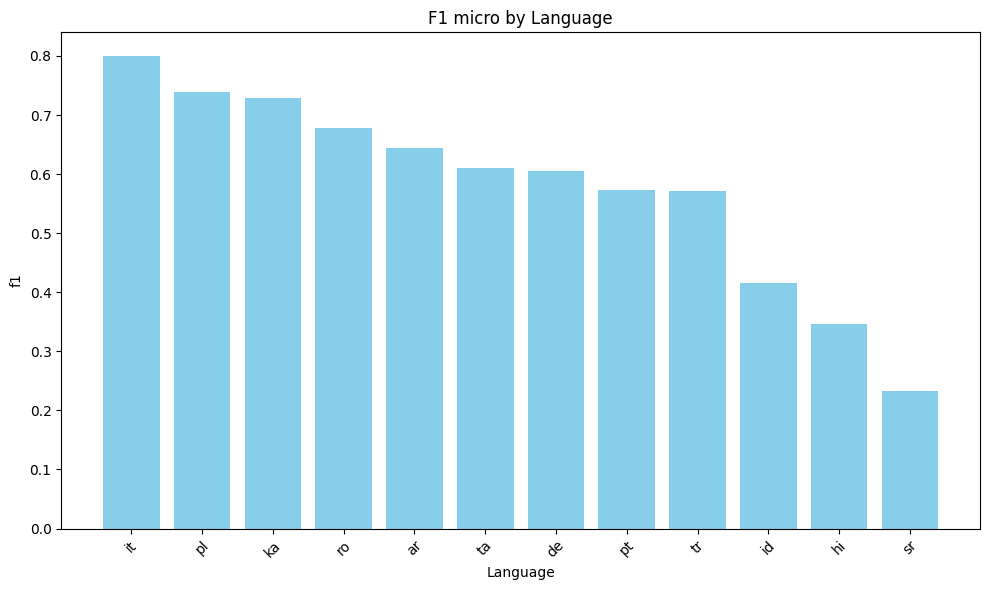

In [111]:
import matplotlib.pyplot as plt


# Sort the data by accuracy in descending order for better visualization
data_sorted = metrics_df.sort_values(by="f1", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(data_sorted["language"], data_sorted["f1"], color="skyblue")
plt.xlabel("Language")
plt.ylabel("f1")
plt.title("F1 micro by Language")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

European vs non european languages

In [127]:
def euro_or_not(lang):
    if lang in ["de", "es", "fr", "it", "no", "nl", "pl", "pt", "ro", "ru", "sr", "sq"]:
        return "European"
    else:
        return "Non-european"


# Apply the euro_or_not function to create a new column 'euro_language'
openai_resp["euro_language"] = openai_resp["language"].apply(euro_or_not)

# Group the DataFrame based on the 'euro_language' column
grouped_euro = openai_resp.groupby("euro_language")

In [128]:
# Apply the custom function to each group and construct a new DataFrame
metrics_df_euro = grouped_euro.apply(calculate_metrics).reset_index()

/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_23288/3067288616.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_euro = grouped_euro.apply(calculate_metrics).reset_index()


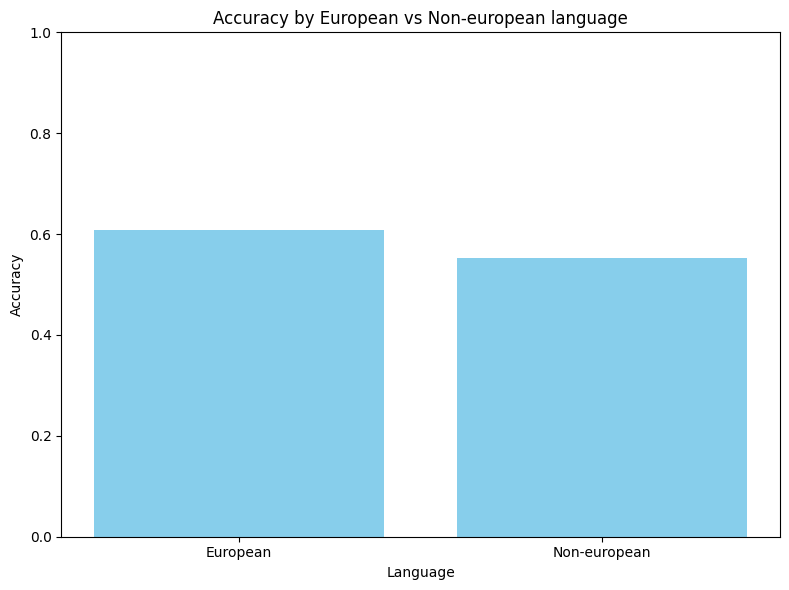

In [129]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics_df_euro["euro_language"], metrics_df_euro["accuracy"], color="skyblue")
plt.xlabel("Language")
plt.ylabel("Accuracy")
plt.title("Accuracy by European vs Non-european language")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [85]:
print(metrics_df_euro)

   euro_language  accuracy        f1  count
0          False  0.553488  0.553488  430.0
1           True  0.608187  0.608187  513.0


Western vs Non-western languages

In [123]:
def western(lang):
    if lang in ["de", "es", "fr", "it", "nl", "no", "pt"]:
        return "Western"
    else:
        return "Non-western"

In [124]:
# Apply the western function to create a new column 'western_language'
openai_resp["western_language"] = openai_resp["language"].apply(western)

# Group the DataFrame based on the 'western_language' column
grouped_western = openai_resp.groupby("western_language")
# Apply the custom function to each group and construct a new DataFrame
metrics_df_western = grouped_western.apply(calculate_metrics).reset_index()
print(metrics_df_western)

  western_language  accuracy        f1  count
0      Non-western  0.565530  0.565530  557.0
1          Western  0.608808  0.608808  386.0


/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_23288/2950847438.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_western = grouped_western.apply(calculate_metrics).reset_index()


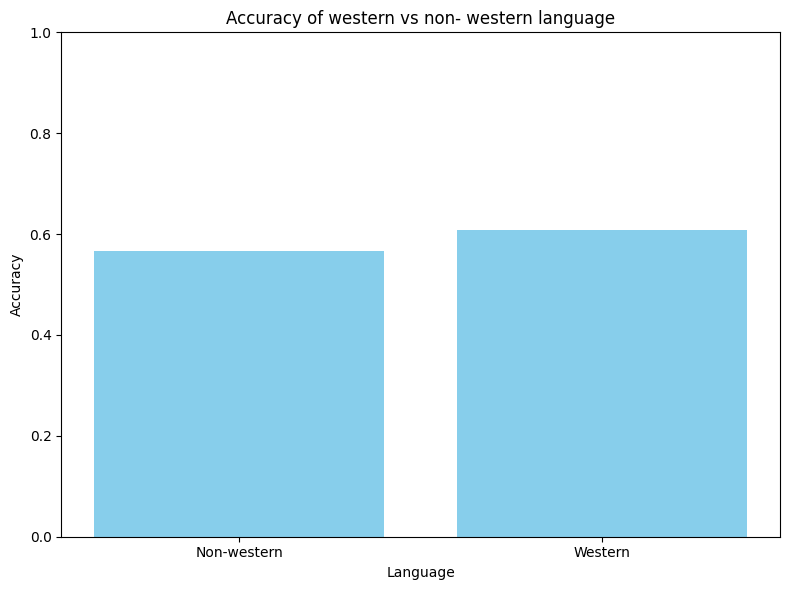

In [126]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(
    metrics_df_western["western_language"],
    metrics_df_western["accuracy"],
    color="skyblue",
)
plt.xlabel("Language")
plt.ylabel("Accuracy")
plt.title("Accuracy of western vs non- western language")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Language classification based on number of speakers(Small, Big)

In [120]:
# languages by size (https://en.wikipedia.org/wiki/List_of_languages_by_total_number_of_speakers)
# <45 m: no, nl, pl, ro, sr, sq, az, ka, si
# >45 m: de, es, fr, it, pt, ru, ar, bn, fa, gu, hi, id, mr, pa, ta, tr
def small(lang):
    if lang in ["no", "nl", "pl", "ro", "sr", "sq", "az", "ka", "si"]:
        return "Small"
    else:
        return "Big"

In [121]:
# Apply the small function to create a new column 'small_language'
openai_resp["small_language"] = openai_resp["language"].apply(small)

# Group the DataFrame based on the 'small_language' column
grouped_small = openai_resp.groupby("small_language")
# Apply the custom function to each group and construct a new DataFrame
metrics_df_small = grouped_small.apply(calculate_metrics).reset_index()
print(metrics_df_small)

  small_language  accuracy        f1  count
0            Big  0.563265  0.563265  735.0
1          Small  0.653846  0.653846  208.0


/var/folders/jb/bp2_sgws1t95lzb193lt3s_w0000gn/T/ipykernel_23288/3847338003.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_small = grouped_small.apply(calculate_metrics).reset_index()


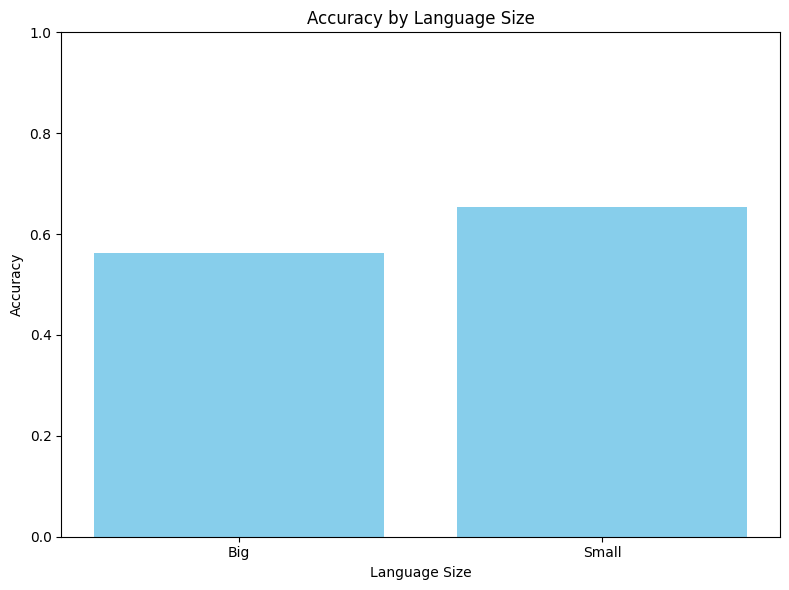

In [122]:
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(
    metrics_df_small["small_language"], metrics_df_small["accuracy"], color="skyblue"
)
plt.xlabel("Language Size")
plt.ylabel("Accuracy")
plt.title("Accuracy by Language Size")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()